In [32]:

from pycytominer.normalize import normalize
import pandas as pd
import numpy as np

# Create dummy data
X = pd.DataFrame(
    {
        "Metadata_plate": ["a", "a", "a", "a", "b", "b", "b", "b"],
        "Metadata_treatment": [
            "drug",
            "drug",
            "control",
            "control",
            "drug",
            "drug",
            "control",
            "control",
        ],
        "x": [1, 2, 8, 2, 5, 5, 5, 1],
        "y": [3, 1, 7, 4, 5, 9, 6, 1],
        "z": [1, 8, 2, 5, 6, 22, 2, 2],
        "zz": [1, 4, 1, 6, 3, 10, 2, 2],
        "yy": [3, 14, 1, 26, 33, 1, 21, 32],
    }
).reset_index(drop=True)

features = ["x", "y", "z", "zz", "yy"]

X = X.assign(Metadata_Batch = "X")
Y = X.copy()
Y.loc[:, features] = np.random.randn(X.shape[0], len(features)) * 10
Y = Y.assign(Metadata_Batch = "Y")

Z = pd.concat([X, Y], axis=0, ignore_index=True)


In [33]:
def run_normalize(df):
    return normalize(        
        profiles=df,
        features=features,
        meta_features="infer",
        samples="Metadata_treatment == 'control'",
        method="Spherize",
        spherize_method="PCA",
        spherize_epsilon=0,
    )

Z = run_normalize(Z)

In [34]:
X = Z.iloc[:X.shape[0], :].copy()
Y = Z.iloc[X.shape[0]:, :].copy()


In [35]:
X = run_normalize(X)
Y = run_normalize(Y)


In [36]:
Xc = X.query("Metadata_treatment == 'control'").loc[:, features]
Yc = Y.query("Metadata_treatment == 'control'").loc[:, features]
Zc = Z.query("Metadata_treatment == 'control'").loc[:, features]

d = Xc.shape[1]

print("Is the covariance matrix of Xc the identity matrix?", np.allclose(Xc.cov(), np.eye(d)))
print("Is the covariance matrix of Yc the identity matrix?", np.allclose(Yc.cov(), np.eye(d)))
print("Is the covariance matrix of Zc the identity matrix?", np.allclose(Zc.cov(), np.eye(d)))

Is the covariance matrix of Xc the identity matrix? False
Is the covariance matrix of Yc the identity matrix? False
Is the covariance matrix of Zc the identity matrix? True


In [37]:
Xc.cov().round(3)

,x,y,z,zz,yy
x,1.0,-0.0,-0.0,0.0,-0.0
y,-0.0,1.0,-0.0,-0.0,-0.0
z,-0.0,-0.0,1.0,-0.0,-0.0
zz,0.0,-0.0,-0.0,0.0,-0.0
yy,-0.0,-0.0,-0.0,-0.0,0.0


In [38]:
Yc.cov().round(3)

,x,y,z,zz,yy
x,1.0,0.0,-0.0,0.0,-0.0
y,0.0,1.0,0.0,-0.0,0.0
z,-0.0,0.0,1.0,0.0,-0.0
zz,0.0,-0.0,0.0,0.0,-0.0
yy,-0.0,0.0,-0.0,-0.0,0.0


In [39]:
Zc.cov().round(3)

,x,y,z,zz,yy
x,1.0,0.0,-0.0,0.0,0.0
y,0.0,1.0,-0.0,0.0,0.0
z,-0.0,-0.0,1.0,-0.0,-0.0
zz,0.0,0.0,-0.0,1.0,0.0
yy,0.0,0.0,-0.0,0.0,1.0


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate random Gaussian distributed data for A and B
n_points = 1000
mean = [0, 0]
cov = [[1, 0.5], [0.5, 4]]

A = np.random.multivariate_normal(mean, cov, n_points)
B = np.random.multivariate_normal(mean, cov, n_points)

# Function to rotate data by a given angle
def rotate_data(data, angle):
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    return data.dot(rotation_matrix)

# Rotate A by 45 degrees to the left and B by 45 degrees to the right
A_rotated = rotate_data(A, 45)
B_rotated = rotate_data(B, -45)

# Convert to dataframes
df_A = pd.DataFrame(A_rotated, columns=['V1', 'V2'])
df_B = pd.DataFrame(B_rotated, columns=['V1', 'V2'])

df_A.head(), df_B.head()



(         V1        V2
 0  0.736548  0.694249
 1  1.915108 -0.419297
 2 -0.514975 -0.094514
 3  3.018242  1.268617
 4 -0.465304 -0.976467,
          V1        V2
 0  0.685153 -1.187522
 1  0.696542 -1.471272
 2  2.402643 -2.983816
 3 -0.636820 -0.455992
 4 -0.049628  1.605906)

In [41]:
# Concatenate A and B vertically
df_AB = pd.concat([df_A, df_B], axis=0, ignore_index=True)
df_AB['Metadata_source'] = ['A'] * len(df_A) + ['B'] * len(df_B)

df_AB.head(), df_AB.tail()


(         V1        V2 Metadata_source
 0  0.736548  0.694249               A
 1  1.915108 -0.419297               A
 2 -0.514975 -0.094514               A
 3  3.018242  1.268617               A
 4 -0.465304 -0.976467               A,
             V1        V2 Metadata_source
 1995  1.628829 -3.032468               B
 1996  2.917570 -2.816561               B
 1997  2.461451 -3.368427               B
 1998  2.205282 -3.584760               B
 1999 -1.660742  2.895401               B)

In [42]:
from pycytominer.normalize import normalize

def run_normalize(df):
    return normalize(        
        profiles=df,
        features=['V1', 'V2'],
        meta_features="infer",
        method="Spherize",
        spherize_method="PCA",
        spherize_epsilon=0,
    )

df_ABs = run_normalize(df_AB)

df_As = run_normalize(df_ABs.query("Metadata_source == 'A'"))
df_Bs = run_normalize(df_ABs.query("Metadata_source == 'B'"))

df_ABs2 = pd.concat([df_As, df_Bs], axis=0, ignore_index=True)


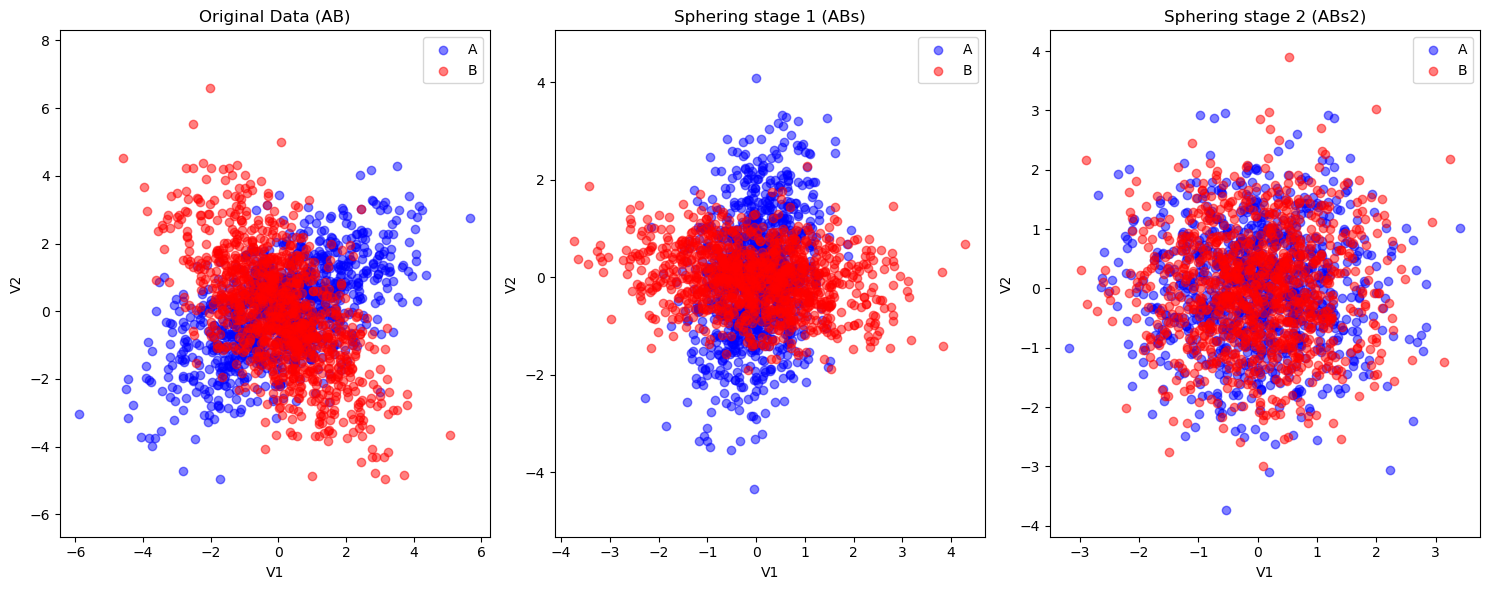

In [43]:
# Plotting the data
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

# Plot df_AB
ax[0].scatter(df_AB[df_AB['Metadata_source'] == 'A']['V1'], df_AB[df_AB['Metadata_source'] == 'A']['V2'], alpha=0.5, label='A', color='blue')
ax[0].scatter(df_AB[df_AB['Metadata_source'] == 'B']['V1'], df_AB[df_AB['Metadata_source'] == 'B']['V2'], alpha=0.5, label='B', color='red')
ax[0].set_title('Original Data (AB)')
ax[0].set_xlabel('V1')
ax[0].set_ylabel('V2')
ax[0].legend()
ax[0].axis('equal')

# Plot df_ABs
ax[1].scatter(df_ABs[df_ABs['Metadata_source'] == 'A']['V1'], df_ABs[df_ABs['Metadata_source'] == 'A']['V2'], alpha=0.5, label='A', color='blue')
ax[1].scatter(df_ABs[df_ABs['Metadata_source'] == 'B']['V1'], df_ABs[df_ABs['Metadata_source'] == 'B']['V2'], alpha=0.5, label='B', color='red')
ax[1].set_title('Sphering stage 1 (ABs)')
ax[1].set_xlabel('V1')
ax[1].set_ylabel('V2')
ax[1].legend()
ax[1].axis('equal')

# Plot df_ABs2
ax[2].scatter(df_ABs2[df_ABs2['Metadata_source'] == 'A']['V1'], df_ABs2[df_ABs2['Metadata_source'] == 'A']['V2'], alpha=0.5, label='A', color='blue')
ax[2].scatter(df_ABs2[df_ABs2['Metadata_source'] == 'B']['V1'], df_ABs2[df_ABs2['Metadata_source'] == 'B']['V2'], alpha=0.5, label='B', color='red')
ax[2].set_title('Sphering stage 2 (ABs2)')
ax[2].set_xlabel('V1')
ax[2].set_ylabel('V2')
ax[2].legend()
ax[2].axis('equal')

plt.tight_layout()
plt.show()
